# Yeast mating pathway 
Author: Je-Hoon Song email: <song.jehoon@gmail.com>

In [1]:
# default settings for jupyter 
%reload_ext autoreload
%autoreload 2
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
import os 
import sys
import numpy as np 
import pandas as pd 
pd.set_option("display.max_columns", 100)
# print(pd.get_option("display.max_columns"))
from ohmyyeast import datasets
# from ohmyyeast import engine 
# matplotlib 
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize

### Load Optimization Data

In [2]:
data_optsnu = datasets.load_optsnu()

In [3]:
data_pub = datasets.load_optpub()
res = data_pub.groupby('AID')['fVal'].agg(['mean','std'])
res2 = res.sort_values('mean').reset_index()

In [4]:
res2.head()

,AID,mean,std
0,618,511.394,70.261493
1,591,520.158,67.407425
2,600,523.236,63.674636
3,631,535.140,33.673449
4,627,539.262,74.155696


### Global fitness and regional analysis 

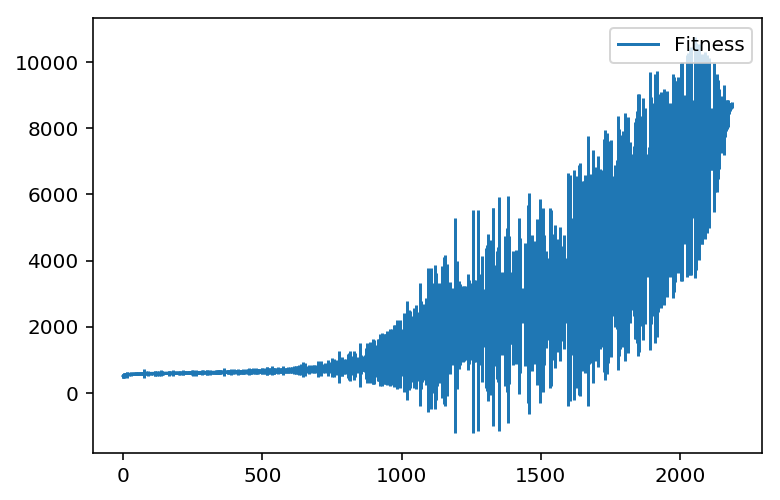

In [5]:
res3 = res2.rename(columns={'mean':'Fitness'})
res3.plot(y='Fitness',yerr='std')
# res3.plot(y=['Fitness'])

여기서 mean, variance의 변화로부터 적절한 separator를 찾을 수 있을까? 

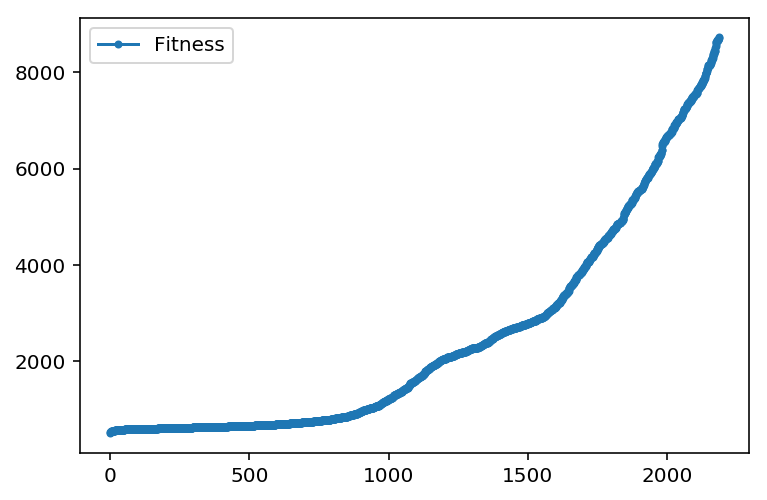

In [6]:
# mean value points are plotted: 
res3.plot(y='Fitness',marker='.')

### Find optimal separator between region-1 and region-2

** Case 1. 4th order polynomial is considered as fitting function.**

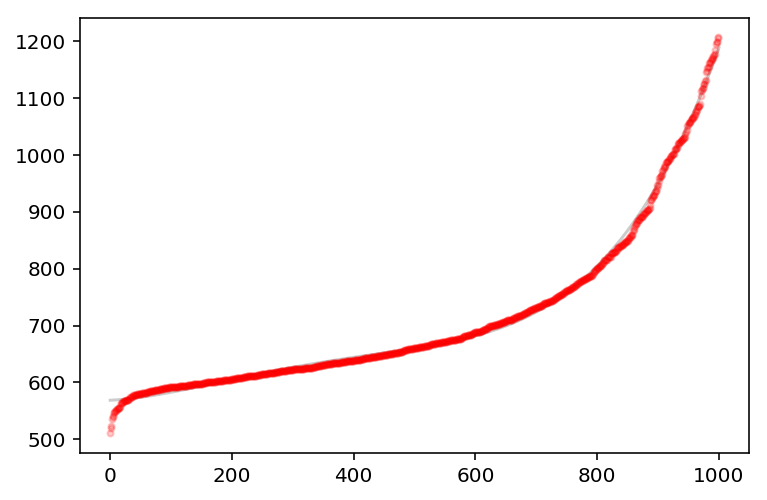

In [7]:
min_x, max_x = 0, 1000
res3a = res3[ (res3.index < max_x) & (res.index > min_x) ]
# res3a = res3
x = res3a.index
y = res3a.Fitness
z = np.polyfit(x, y, 4)
p = np.poly1d(z)
p_d = p.deriv(1)
xp = np.linspace(0, max_x, 100)
yp = p(xp)
yp_d = p_d(xp)
# fitted result: 
plt.plot(xp,yp,'k-',res3a.index,res3a.Fitness,'r.',alpha=0.2)

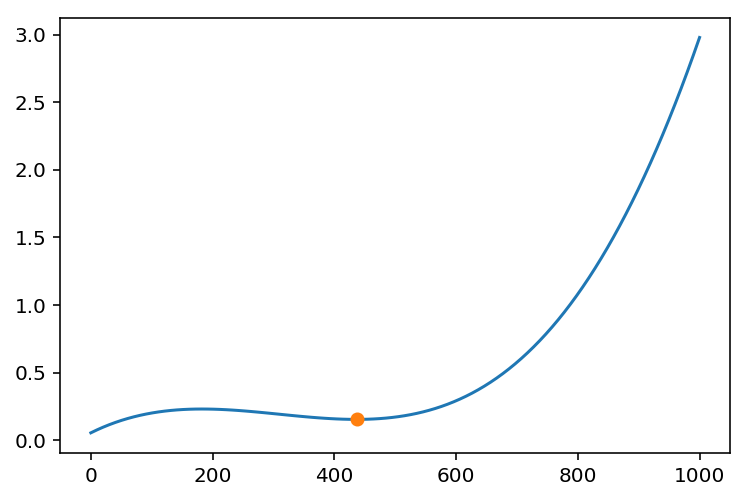

In [8]:
x_opt = optimize.minimize(p_d, 550).x[0]
plt.plot(xp,yp_d, x_opt, p_d(x_opt), 'o')

In [9]:
print('x_opt =', x_opt)
print('f_opt =', p(x_opt))
polyopt_res = {} 
polyopt_res['4th'] = {'x_opt': x_opt, 'f_opt': p(x_opt)}

x_opt = 436.64626295297643
f_opt = 649.8187330633959


** Case 2. 3rd order polynomial is considered as fitting function.**

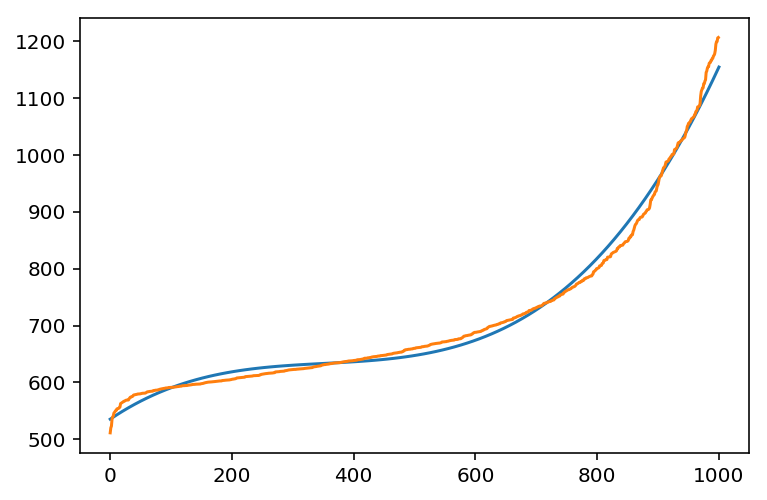

In [10]:
x,y = res3a.index, res3a.Fitness
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
p_d = p.deriv()
xp = np.linspace(0, max_x, 100)
yp = p(xp)
yp_d = p_d(xp)
plt.plot(xp,yp,res3a.index,res3a.Fitness)

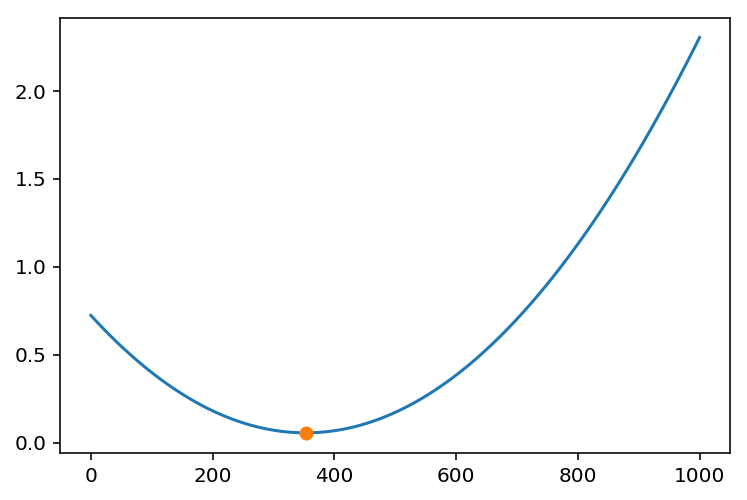

In [11]:
#from scipy.optimize import newton_krylov as newton
#newton(-p_d, [200,500])
from scipy import optimize
x_opt = optimize.minimize(p_d,400).x[0]
plt.plot(xp, yp_d, x_opt, p_d(x_opt), 'o')

In [12]:
print('x_opt =', x_opt)
print('f_opt =', p(x_opt))

polyopt_res['3rd'] = {'x_opt': x_opt, 'f_opt': p(x_opt)}

x_opt = 352.79173716819025
f_opt = 633.4864184675258


** Case 3. 2nd order polynomial is considered as fitting function.**

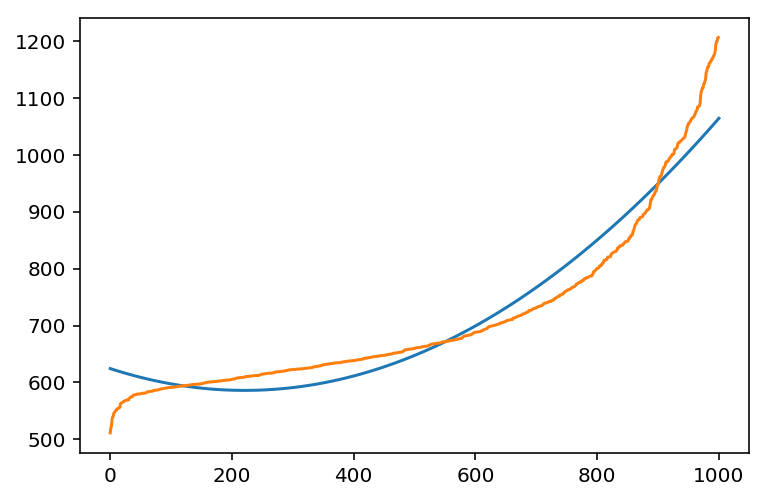

In [13]:
x,y = res3a.index, res3a.Fitness
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
p_d = p.deriv()
xp = np.linspace(0, max_x, 100)
yp = p(xp)
yp_d = p_d(xp)
# fitted result: 
plt.plot(xp,yp,res3a.index,res3a.Fitness); 
#plt.xlim([0,600])

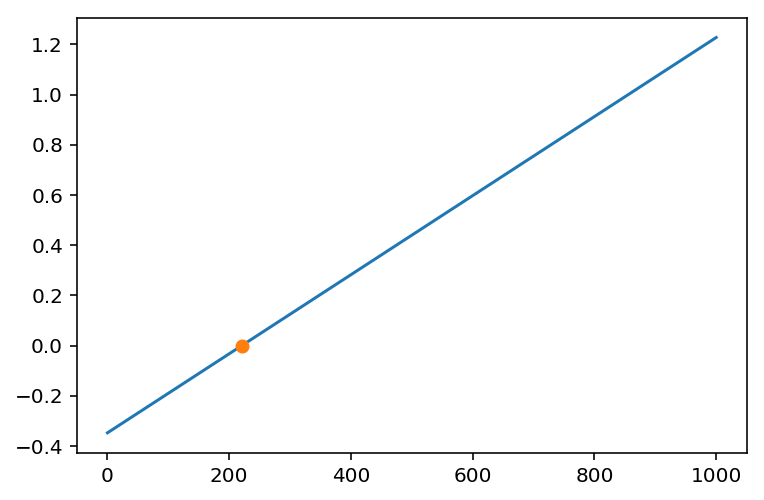

In [14]:
#from scipy.optimize import newton_krylov as newton
#newton(-p_d, [200,500])
from scipy import optimize
x_opt = optimize.minimize(lambda x: p_d(x)*p_d(x),400).x[0]
plt.plot(xp, yp_d, x_opt, p_d(x_opt), 'o')

In [15]:
print('x_opt =', x_opt)
print('f_opt =', p(x_opt))

polyopt_res['2nd'] = {'x_opt': x_opt, 'f_opt': p(x_opt)}

x_opt = 220.64359645469773
f_opt = 586.0082252549483


In [16]:
polyopt_res

{'2nd': {'f_opt': 586.0082252549483, 'x_opt': 220.64359645469773},
 '3rd': {'f_opt': 633.4864184675258, 'x_opt': 352.79173716819025},
 '4th': {'f_opt': 649.8187330633959, 'x_opt': 436.64626295297643}}

### Core structures

Now are studying about the core structures. 

In [17]:
def pattern_generator(k): 
    from itertools import combinations, permutations, product
    thr_corestrt = 650
    data_optsnu.columns
    data_optsnu.head()
    all_edges = ['e2','e3','e4','e5','e6','e7','e8','e9','e10']
    #unfixed_edges = ['e2','e3','e4','e6','e7','e9','e10']
    unfixed_edges = ['e2','e3','e4','e6','e7','e10']
    kstrlist = list()
    kstrlist_short = list() 
    for edge_key in combinations(unfixed_edges, k): 
        for edge_value in product([0,1,2], repeat=k):
            templ = {'e2':'*','e3':'*','e4':'*','e5':'1!','e6':'*','e7':'*','e8':'1!','e9':'*','e10':'*'}
            templ_short = {} 
            for ek, ev in zip(edge_key, edge_value):
                templ[ek] = ev 
                templ_short[ek] = ev 

            kstrlist.append(templ)
            kstrlist_short.append(templ_short)
    return kstrlist, kstrlist_short

In [18]:
def RelativeAppearance(data_optsnu,thr=650,K=3,target={'e3': 2, 'e6': 2}):
    targl = [(k,target[k]) for k in target]
    kstr, kstr_short = pattern_generator(K)
    # kstr_short[0:5]
    # pd.DataFrame(kstr).head(20)
    kstr_queries = [" and ".join([ x + ' == ' + str(xxx[x]) 
                                  for x in xxx]) 
          for xxx in kstr_short]
    kstr_meanfVal = [ {'Nin':(data_optsnu.query(kq).fVal < thr).sum(),
                       'Nout':(data_optsnu.query(kq).fVal >= thr).sum(),
                       'A_R':(data_optsnu.query(kq).fVal < thr).sum()/(
                           data_optsnu.query(kq).fVal >= thr).sum()
                      }  
                     for kq in kstr_queries]
    kstr_RelA = pd.DataFrame(kstr_meanfVal)
    kstr_RelA['Structure'] = kstr_short
    kstr_RelA['kstrl'] = kstr_RelA.Structure.apply(
        lambda x : [(k,x[k]) for k in x])
    kstr_RelA['#Feedback'] = kstr_RelA.kstrl.apply(
        lambda kstrl: len([k for k in kstrl if k in targl]))
    kstr_RelA = kstr_RelA.sort_values('A_R', ascending=False)
    kstr_RelA.drop(columns=['kstrl'], inplace=True)
    return kstr_RelA 

<img src="3node-structure.png" width=300>

In [19]:
data_optsnu.index.name='Structure ID'

In [20]:
data_optsnu.head()

,AID,e2,e3,e4,e5,e6,e7,e8,e9,e10,S,k_SA,K_SA,k_BA,K_BA,ki_BA,Ki_BA,k_CA,K_CA,ki_CA,Ki_CA,k_AA,K_AA,ki_AA,Ki_AA,k_AB,K_AB,ki_AB,Ki_AB,k_CB,K_CB,ki_CB,Ki_CB,k_BB,K_BB,ki_BB,Ki_BB,k_BC,K_BC,ki_BC,Ki_BC,k_AC,K_AC,ki_AC,Ki_AC,k_CC,K_CC,ki_CC,Ki_CC,ki_EA,Ki_EA,ki_EB,Ki_EB,ki_EC,Ki_EC,k_FA,K_FA,k_FB,K_FB,k_FC,K_FC,Afus1,kd,ks,At,Bt,Ct,E,F,fVal
Structure ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,1,0,0,1.000000e-300,990.33,18.731,128.420,36.258,172.520,160.90,13.430,135.870,27.429,608.150,108.380,92.718,393.960,18.536,81.382,52.019,267.610,158.640,34.681,47.986,38.641,65.448,55.817,55.203,172.370,68.338,12.114,46.281,137.010,35.582,55.889,114.700,14.819,262.52,12.680,61.028,649.820,760.080,897.19,13.951,728.68,17.657,988.42,492.710,58.952,10.611,87.353,60.216,40.484,999.48,0.6931,1,0.4019,60.23,38.9,363.59,1,1,1018.90
1,1,0,0,0,1,0,0,1,0,0,1.000000e-300,999.97,114.500,29.544,56.874,40.608,112.58,458.460,573.310,313.370,32.502,46.996,138.270,487.700,18.579,59.371,55.650,641.960,13.387,26.728,437.070,583.580,786.150,952.030,205.920,11.471,24.330,302.170,336.900,686.330,13.067,32.115,47.463,217.110,129.82,14.043,846.540,182.070,32.726,823.44,15.427,774.13,14.171,462.48,32.726,10.669,10.045,14.453,20.486,393.290,576.26,0.6931,1,0.4019,60.23,38.9,363.59,1,1,822.60
2,1,0,0,0,1,0,0,1,0,0,1.000000e-300,163.60,27.267,345.720,36.144,51.854,737.86,116.000,26.027,36.905,426.730,14.147,16.320,37.777,13.730,20.161,109.630,432.040,242.980,27.111,109.790,12.610,30.936,122.050,17.851,174.570,518.070,34.276,145.010,409.010,257.740,95.487,93.048,30.138,118.23,13.920,529.620,173.310,40.768,399.07,13.718,904.38,131.430,667.46,234.940,11.071,160.080,13.561,481.820,10.694,986.12,0.6931,1,0.4019,60.23,38.9,363.59,1,1,913.48
3,1,0,0,0,1,0,0,1,0,0,1.000000e-300,461.08,22.017,11.935,136.270,18.654,150.37,548.520,384.230,23.662,53.945,39.879,623.400,17.435,671.070,10.883,50.766,259.090,221.930,252.780,152.990,10.748,87.115,96.290,37.058,301.110,14.539,16.125,65.357,10.367,957.440,73.279,153.010,190.650,123.08,537.200,347.770,263.440,25.859,946.68,36.409,759.62,82.958,934.00,565.890,18.844,404.150,22.505,138.440,10.004,998.57,0.6931,1,0.4019,60.23,38.9,363.59,1,1,794.64
4,1,0,0,0,1,0,0,1,0,0,1.000000e-300,365.34,17.338,34.473,24.369,18.226,128.17,22.593,514.350,20.105,348.020,103.240,325.280,24.278,57.678,24.378,199.280,44.937,31.303,26.405,636.370,915.020,302.210,135.680,63.749,103.230,893.950,15.302,208.570,36.852,62.586,13.837,606.350,107.860,963.03,609.580,27.805,29.626,778.630,884.52,48.105,869.19,145.340,823.44,488.320,11.632,10.463,15.206,249.650,10.344,963.20,0.6931,1,0.4019,60.23,38.9,363.59,1,1,927.29


In [21]:
data_optsnu.sort_values('fVal').head()

,AID,e2,e3,e4,e5,e6,e7,e8,e9,e10,S,k_SA,K_SA,k_BA,K_BA,ki_BA,Ki_BA,k_CA,K_CA,ki_CA,Ki_CA,k_AA,K_AA,ki_AA,Ki_AA,k_AB,K_AB,ki_AB,Ki_AB,k_CB,K_CB,ki_CB,Ki_CB,k_BB,K_BB,ki_BB,Ki_BB,k_BC,K_BC,ki_BC,Ki_BC,k_AC,K_AC,ki_AC,Ki_AC,k_CC,K_CC,ki_CC,Ki_CC,ki_EA,Ki_EA,ki_EB,Ki_EB,ki_EC,Ki_EC,k_FA,K_FA,k_FB,K_FB,k_FC,K_FC,Afus1,kd,ks,At,Bt,Ct,E,F,fVal
Structure ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13502,1351,1,2,1,1,2,0,1,0,0,1.000000e-300,966.18,38.753,34.936,371.450,33.808,412.520,349.700,115.720,25.426,392.140,11.383,875.76,285.170,22.020,27.690,43.098,44.723,694.880,464.070,402.190,718.800,19.745,397.840,16.247,434.370,252.440,440.460,50.834,73.099,77.578,325.55,65.648,729.410,40.098,14.361,65.129,212.010,40.356,595.60,41.080,57.149,957.540,60.598,17.535,12.503,332.35,10.459,55.116,15.677,163.660,0.6931,1,0.4019,60.23,38.9,363.59,1,1,447.90
5728,573,0,2,1,1,0,0,1,1,2,1.000000e-300,804.19,55.203,30.901,581.180,11.510,356.500,19.101,89.001,11.347,62.991,18.815,802.68,63.476,32.555,12.128,337.290,338.580,674.870,12.456,23.659,61.870,254.600,33.662,968.420,525.430,15.105,10.818,70.843,22.215,79.959,516.24,12.879,764.590,65.982,197.140,204.810,234.180,25.075,459.93,17.868,122.690,264.010,196.150,166.540,36.408,393.42,11.882,561.350,56.586,10.075,0.6931,1,0.4019,60.23,38.9,363.59,1,1,453.14
6449,645,0,2,1,1,2,2,1,1,2,1.000000e-300,951.21,19.810,226.660,66.176,765.750,755.160,785.350,100.000,12.985,108.520,12.098,321.87,172.900,10.934,778.100,286.480,17.189,103.650,66.229,20.035,36.843,57.150,17.783,149.130,10.000,386.830,13.443,396.550,791.610,100.000,426.75,130.600,68.997,26.813,41.473,27.287,81.112,32.880,258.10,10.023,303.590,37.200,352.560,565.210,15.171,592.57,261.410,12.724,176.740,116.300,0.6931,1,0.4019,60.23,38.9,363.59,1,1,454.98
6173,618,0,2,1,1,1,2,1,1,2,1.000000e-300,832.73,69.000,14.031,111.790,677.850,12.425,417.450,626.200,32.008,586.090,12.397,640.70,29.166,624.680,499.950,42.881,100.710,96.727,10.536,25.165,90.439,75.408,29.662,317.770,15.999,158.330,11.170,10.782,904.190,226.840,896.22,168.300,388.270,43.726,391.640,787.040,289.950,37.746,357.08,15.331,499.070,13.351,982.280,132.390,34.010,840.99,168.820,21.136,362.370,626.230,0.6931,1,0.4019,60.23,38.9,363.59,1,1,456.25
6447,645,0,2,1,1,2,2,1,1,2,1.000000e-300,898.70,95.412,74.205,124.830,29.256,69.053,164.430,668.230,16.848,234.140,11.499,730.02,22.314,100.850,911.120,57.900,13.231,68.957,30.017,68.525,21.110,18.765,14.531,471.770,34.831,24.339,42.511,81.021,17.999,456.250,907.03,80.723,614.910,544.380,298.240,399.350,387.220,10.536,346.51,25.772,35.315,368.080,512.530,12.352,18.754,138.03,48.151,365.440,28.995,18.914,0.6931,1,0.4019,60.23,38.9,363.59,1,1,460.43


### in case that K = 2

In [22]:
res = RelativeAppearance(data_optsnu,thr=500,K=2)
res.to_csv('k2-thr500.csv')
# res.head(10)

In [23]:
res = RelativeAppearance(data_optsnu,thr=550,K=2)
res.to_csv('k2-thr550.csv')
# res.head(10)

In [24]:
res = RelativeAppearance(data_optsnu,thr=600,K=2)
res.to_csv('k2-thr600.csv')
# res.head(10)

In [25]:
res = RelativeAppearance(data_optsnu,thr=650,K=2)
res.to_csv('k2-thr650.csv')
# res.head(10)

In [26]:
res = RelativeAppearance(data_optsnu,thr=700,K=2)
res.to_csv('k2-thr700.csv')
# res.head(10)

In [27]:
res = RelativeAppearance(data_optsnu,thr=750,K=2)
res.to_csv('k2-thr750.csv')
# res.head(10)

In [28]:
polyopt_res

{'2nd': {'f_opt': 586.0082252549483, 'x_opt': 220.64359645469773},
 '3rd': {'f_opt': 633.4864184675258, 'x_opt': 352.79173716819025},
 '4th': {'f_opt': 649.8187330633959, 'x_opt': 436.64626295297643}}

In [29]:
for key in polyopt_res:
    thr = polyopt_res[key]['f_opt']
    res = RelativeAppearance(data_optsnu,thr=thr,K=2)
    res.to_csv('opt-k2-thr%d.csv' % thr)

### in case that K = 3 

In [30]:
res = RelativeAppearance(data_optsnu,thr=500,K=3)
res.to_csv('k3-thr500.csv')
# res.head(10)

In [31]:
res = RelativeAppearance(data_optsnu,thr=550,K=3)
res.to_csv('k3-thr550.csv')
# k3thr550.head(10)

In [32]:
res = RelativeAppearance(data_optsnu,thr=600,K=3)
res.to_csv('k3-thr600.csv')
# res.head(10)

In [33]:
res = RelativeAppearance(data_optsnu,thr=650,K=3)
res.to_csv('k3-thr650.csv')
# k3thr650.head(10)

In [34]:
res = RelativeAppearance(data_optsnu,thr=700,K=3)
res.to_csv('k3-thr700.csv')
# k3thr700.head(10)

In [35]:
res = RelativeAppearance(data_optsnu,thr=750,K=3)
res.to_csv('k3-thr750.csv')
# res.head(10)

In [36]:
for key in polyopt_res:
    thr = polyopt_res[key]['f_opt']
    res = RelativeAppearance(data_optsnu,thr=thr,K=3)
    res.to_csv('opt-k3-thr%d.csv' % thr)

### in case that K = 4

In [37]:
res = RelativeAppearance(data_optsnu,thr=500,K=4)
res.to_csv('k4-thr500.csv')
# res.head()

In [38]:
res = RelativeAppearance(data_optsnu,thr=550,K=4)
res.to_csv('k4-thr550.csv')
# res.head()

In [39]:
res = RelativeAppearance(data_optsnu,thr=600,K=4)
res.to_csv('k4-thr600.csv')
# res.head(10)

In [40]:
res = RelativeAppearance(data_optsnu,thr=650,K=4)
res.to_csv('k4-thr650.csv')
# res.head(10)

In [41]:
res = RelativeAppearance(data_optsnu,thr=700,K=4)
res.to_csv('k4-thr700.csv')
# res.head(10)

In [42]:
for key in polyopt_res:
    thr = polyopt_res[key]['f_opt']
    res = RelativeAppearance(data_optsnu,thr=thr,K=4)
    res.to_csv('opt-k4-thr%d.csv' % thr)

In [43]:
#이 부분은 필요없음
#thr_list = [500,550,600,650,700,750]
#K_list = [2,3,4]
#for thr in thr_list:
#    for K in K_list: 
#        res = RelativeAppearance(data_optsnu,thr=thr,K=K)
#        res.to_csv('table-SX-thr%d-K%d.csv' % (thr, K))

In [44]:
# 결과 요약하기 

In [45]:
res_list = [] 

for K in [2,3,4]:
    for key in polyopt_res:
        thr = polyopt_res[key]['f_opt']
        thefile = 'opt-k%d-thr%d.csv' % (K,thr)
        thedf0 = pd.read_csv(thefile)
        thedf0['thr'] = float('%.02f' % thr)
        thedf0['K'] = K
        thedf0['mode'] = 'OPT'
        res_list.append(thedf0)
        
for K in [2,3,4]:
    for thr in [500,550,600,650,700]:
        thefile = 'k%d-thr%d.csv' % (K,thr)
        thedf0 = pd.read_csv(thefile)
        thedf0['thr'] = thr
        thedf0['K'] = K
        thedf0['mode'] = 'MAN'
        res_list.append(thedf0)        

In [46]:
df_all = pd.concat(res_list)
# df_all.head()
df_all.drop(columns=['Unnamed: 0'])
df_all.head()
# res_list

,Unnamed: 0,A_R,Nin,Nout,Structure,#Feedback,thr,K,mode
0,125,1.667398,1519,911,"{'e6': 2, 'e10': 2}",1,649.82,2,OPT
1,80,1.396450,1416,1014,"{'e10': 2, 'e3': 2}",1,649.82,2,OPT
2,62,1.305503,1376,1054,"{'e6': 2, 'e3': 2}",2,649.82,2,OPT
3,78,1.254174,1352,1078,"{'e10': 0, 'e3': 2}",1,649.82,2,OPT
4,123,1.129711,1289,1141,"{'e6': 2, 'e10': 0}",1,649.82,2,OPT


In [47]:
df_all_opt = df_all[df_all['mode']=='OPT']
df_all_man = df_all[df_all['mode']=='MAN']

In [48]:
df_all_opt

,Unnamed: 0,A_R,Nin,Nout,Structure,#Feedback,thr,K,mode
0,125,1.667398,1519,911,"{'e6': 2, 'e10': 2}",1,649.82,2,OPT
1,80,1.396450,1416,1014,"{'e10': 2, 'e3': 2}",1,649.82,2,OPT
2,62,1.305503,1376,1054,"{'e6': 2, 'e3': 2}",2,649.82,2,OPT
3,78,1.254174,1352,1078,"{'e10': 0, 'e3': 2}",1,649.82,2,OPT
4,123,1.129711,1289,1141,"{'e6': 2, 'e10': 0}",1,649.82,2,OPT
5,74,1.084048,1264,1166,"{'e10': 2, 'e3': 0}",0,649.82,2,OPT
6,44,1.001647,1216,1214,"{'e2': 2, 'e10': 2}",0,649.82,2,OPT
7,134,0.995074,1212,1218,"{'e7': 2, 'e10': 2}",0,649.82,2,OPT
8,119,0.936255,1175,1255,"{'e6': 0, 'e10': 2}",0,649.82,2,OPT
9,107,0.919431,1164,1266,"{'e4': 2, 'e10': 2}",0,649.82,2,OPT


### Group-by = 'K'

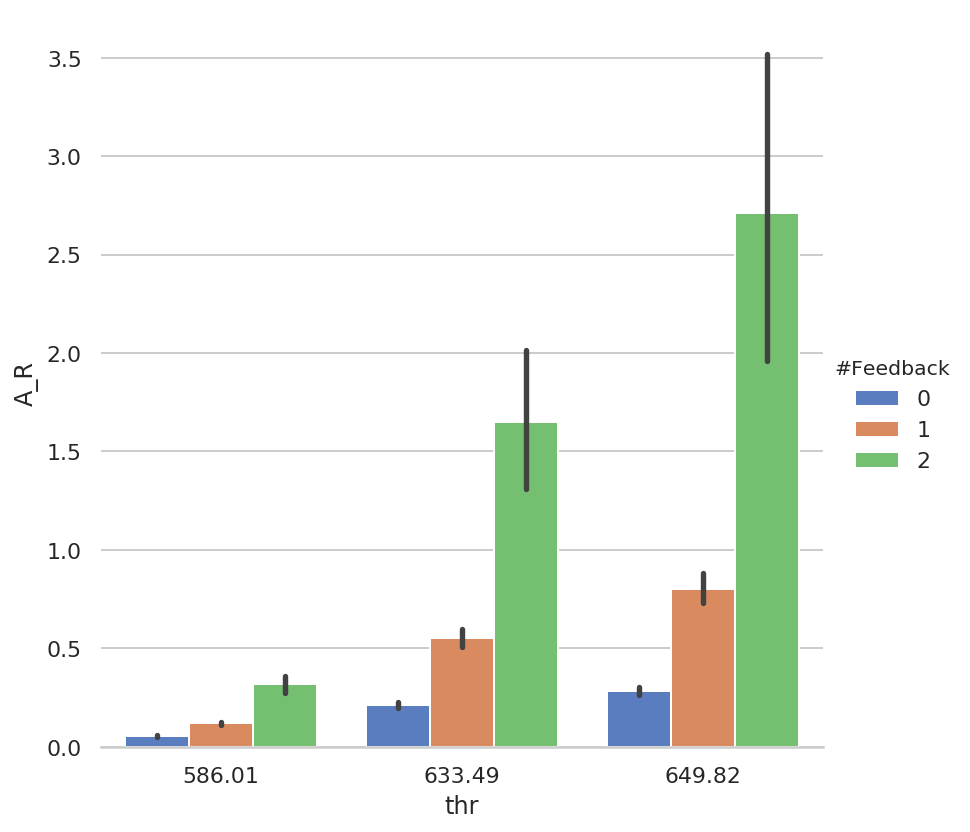

In [49]:
# mode = OPT
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="thr", y="A_R", hue="#Feedback", data=df_all_opt,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
# g.set_ylabels("survival probability")

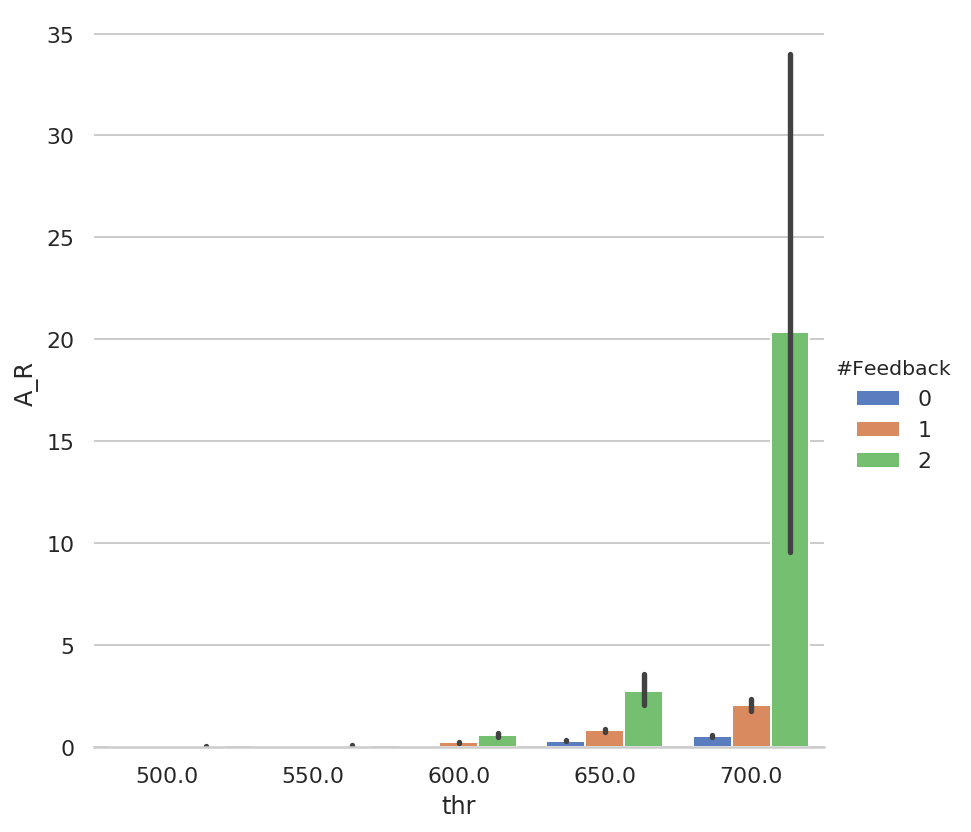

In [50]:
# mode = MAN
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="thr", y="A_R", hue="#Feedback", data=df_all_man,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
# g.set_ylabels("survival probability")

### Group-by = 'thr'

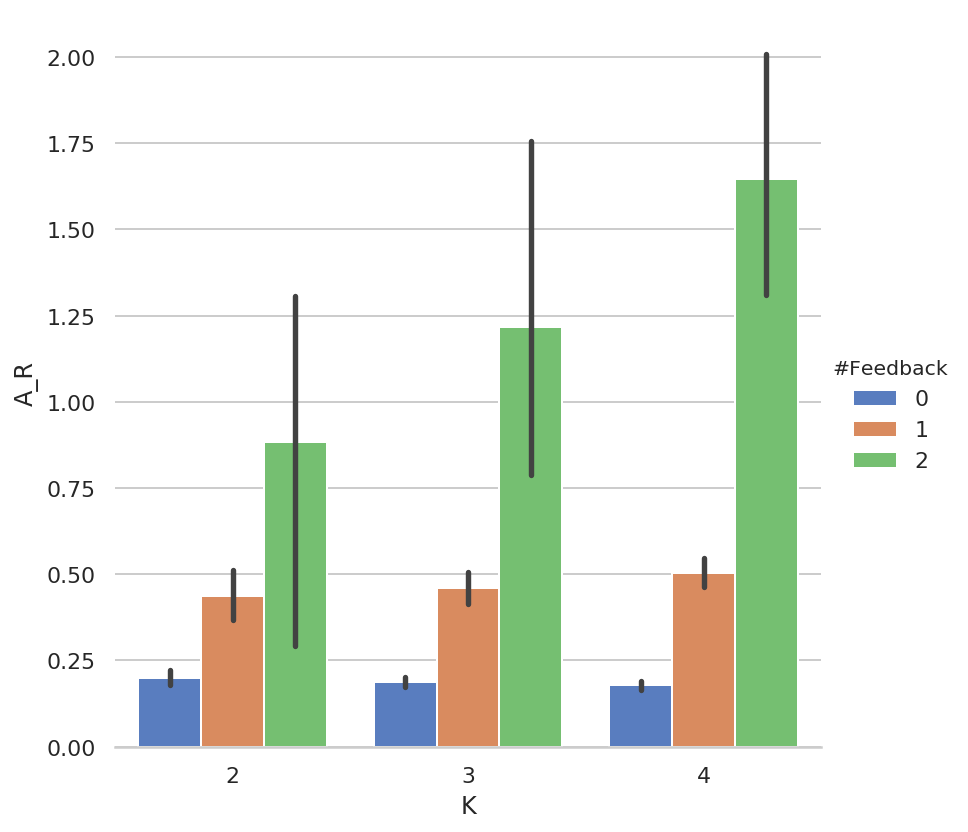

In [51]:
# mode = OPT
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="K", y="A_R", hue="#Feedback", data=df_all_opt,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
# g.set_ylabels("survival probability")

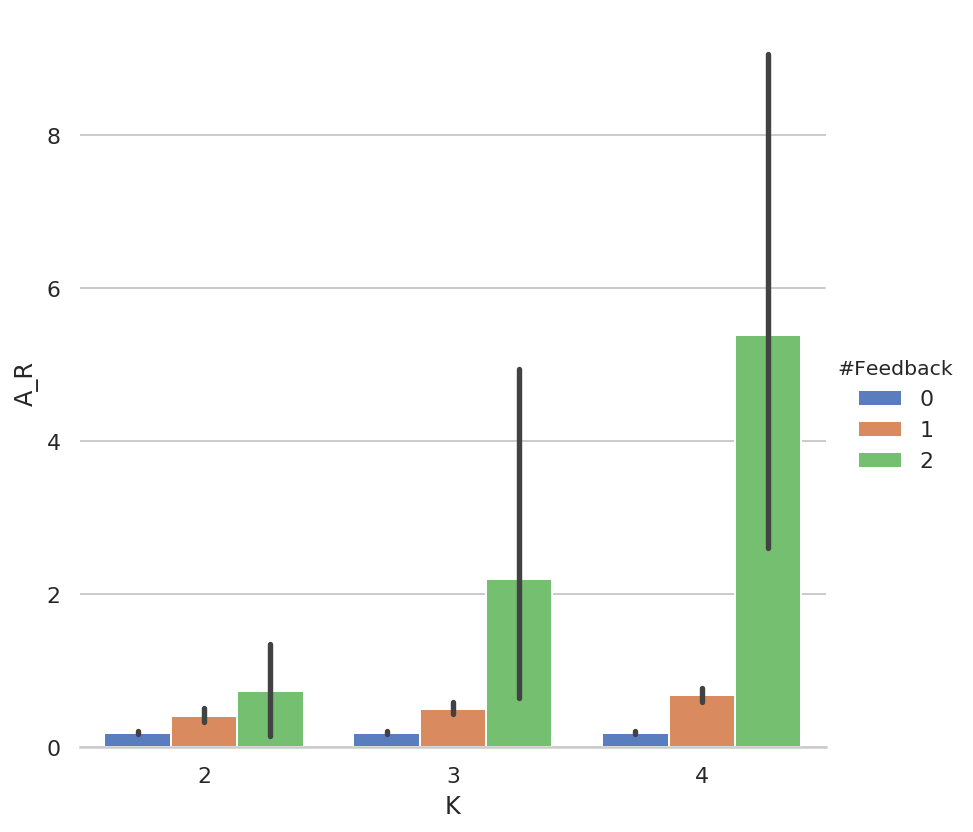

In [52]:
# mode = MAN
import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="K", y="A_R", hue="#Feedback", data=df_all_man,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
# g.set_ylabels("survival probability")

### 여기서 A_R = Nin/Nout 이 평균을 취하면 안되는 값이라고 비판을 할 수도 있다.

좀 더 나은 방식은 다음과 같이 Nin, Nout population 들을 더한후, 그들의 비율을 구하는 것이다. 
$$ A_R = \frac{\sum_j{Nin_j} } { \sum_j{Nout_j} } $$

In [53]:
# mode = OPT 

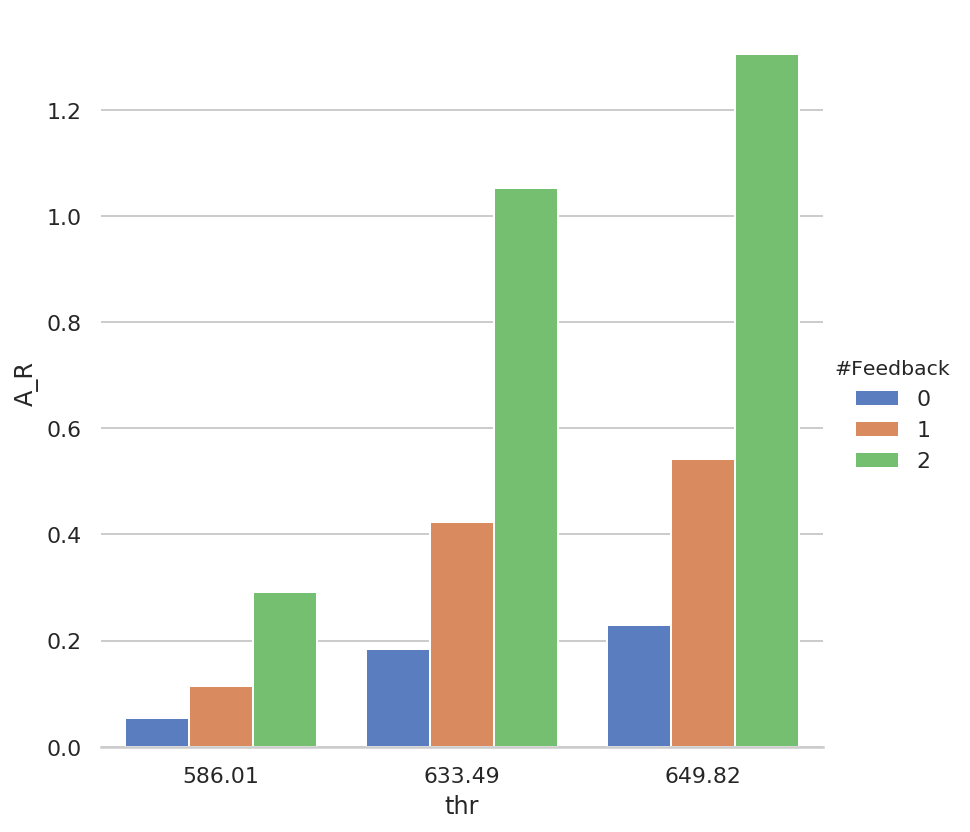

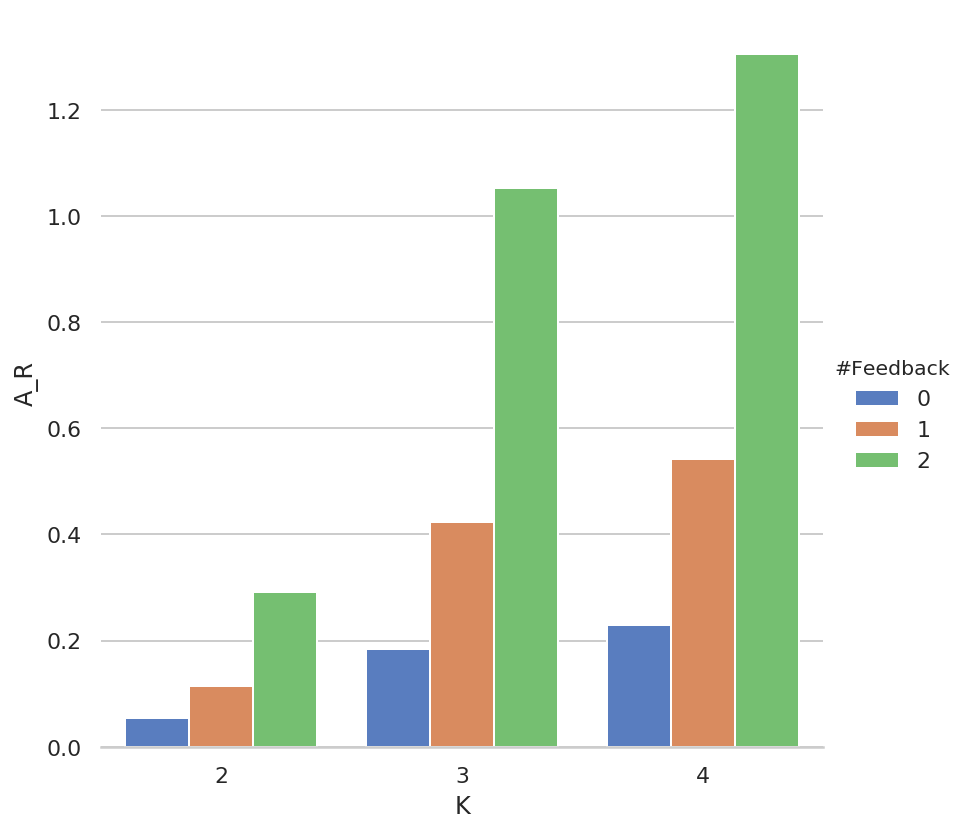

In [54]:
#################
# rand-var : K 
#################
df_all_opt_agg_K = df_all_opt.groupby(['thr','#Feedback']).sum()[['Nin','Nout']].reset_index()
df_all_opt_agg_K['A_R'] = df_all_opt_agg_K.Nin / df_all_opt_agg_K.Nout
# df_all_opt_agg_K

import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="thr", y="A_R", hue="#Feedback", data=df_all_opt_agg_K,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

#################
# rand-var : thr
#################
df_all_opt_agg_thr = df_all_opt.groupby(['K','#Feedback']).sum()[['Nin','Nout']].reset_index()
df_all_opt_agg_thr['A_R'] = df_all_opt_agg_K.Nin / df_all_opt_agg_K.Nout
# df_all_opt_agg_thr

import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="K", y="A_R", hue="#Feedback", data=df_all_opt_agg_thr,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

In [55]:
# mode: MAN

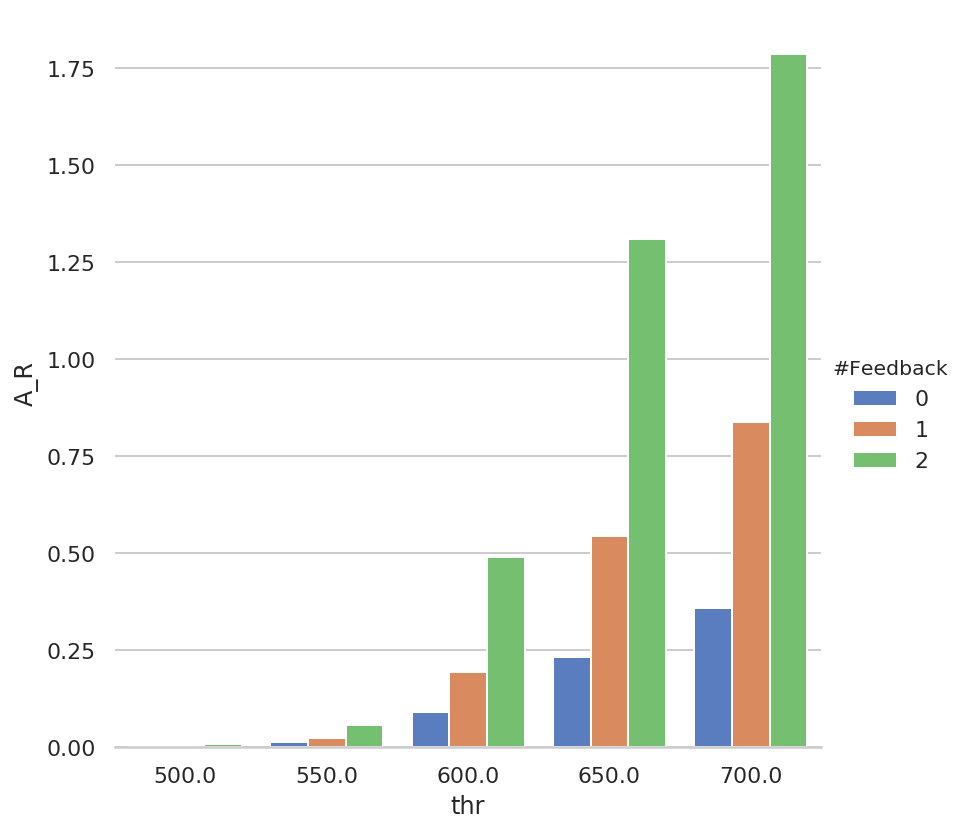

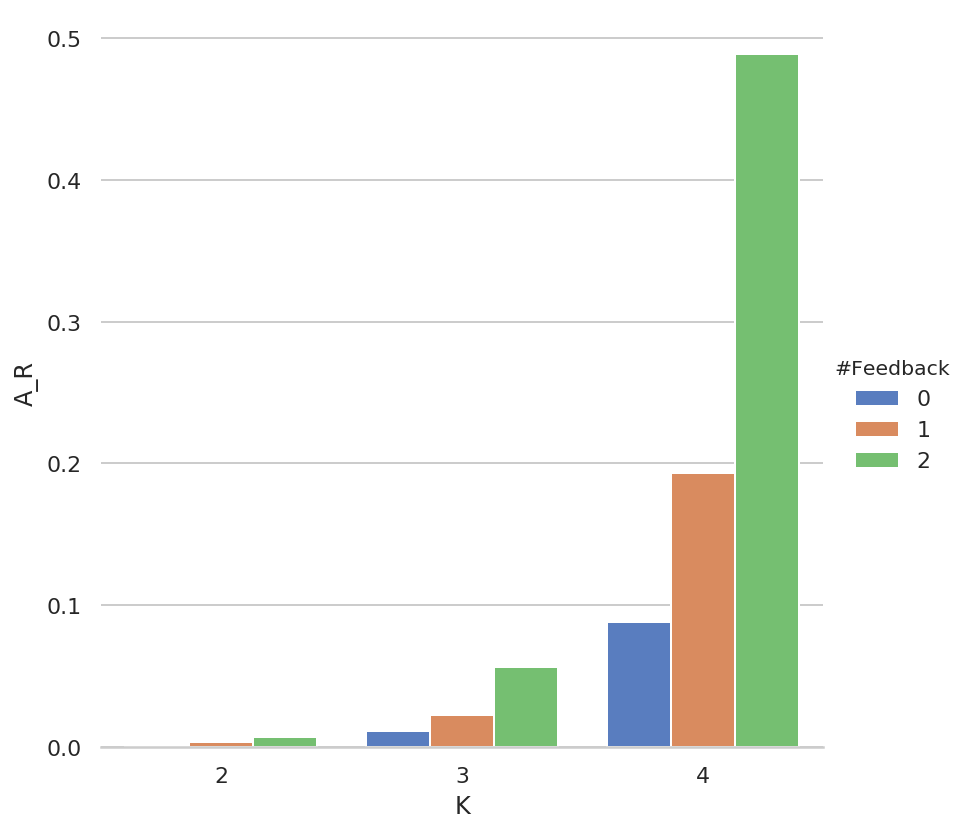

In [56]:
#################
# rand-var : K 
#################
df_all_man_agg_K = df_all_man.groupby(['thr','#Feedback']).sum()[['Nin','Nout']].reset_index()
df_all_man_agg_K['A_R'] = df_all_man_agg_K.Nin / df_all_man_agg_K.Nout
# df_all_opt_agg_K

import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="thr", y="A_R", hue="#Feedback", data=df_all_man_agg_K,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

#################
# rand-var : thr
#################
df_all_man_agg_thr = df_all_opt.groupby(['K','#Feedback']).sum()[['Nin','Nout']].reset_index()
df_all_man_agg_thr['A_R'] = df_all_man_agg_K.Nin / df_all_man_agg_K.Nout
# df_all_opt_agg_thr

import seaborn as sns
sns.set(style="whitegrid")

g = sns.catplot(x="K", y="A_R", hue="#Feedback", data=df_all_man_agg_thr,
                height=6, kind="bar", palette="muted")
g.despine(left=True)

### Fisher's exact test
최종적으로, dual negative feedback이 있으면, fitness curve의 왼쪽으로 이동한다는, 즉 실험데이터에 잘 부합하게 된다는, 또는 내재한 메커니즘이 듀얼네가티브 피드백이라는 결론을 내리기 위해서 fisher's exact test를 수행한다.

가설: *dual negative feedback 이 있는 경우, 구조가 더 좋은 fitness를 가지게 된다.*

In [57]:
df_all['DUAL_NFB'] = df_all['#Feedback'] == 2
df_all.head()

,Unnamed: 0,A_R,Nin,Nout,Structure,#Feedback,thr,K,mode,DUAL_NFB
0,125,1.667398,1519,911,"{'e6': 2, 'e10': 2}",1,649.82,2,OPT,False
1,80,1.396450,1416,1014,"{'e10': 2, 'e3': 2}",1,649.82,2,OPT,False
2,62,1.305503,1376,1054,"{'e6': 2, 'e3': 2}",2,649.82,2,OPT,True
3,78,1.254174,1352,1078,"{'e10': 0, 'e3': 2}",1,649.82,2,OPT,False
4,123,1.129711,1289,1141,"{'e6': 2, 'e10': 0}",1,649.82,2,OPT,False


In [58]:
df_all_contin = df_all.groupby('DUAL_NFB').sum()[['Nin','Nout']].reset_index().sort_values('DUAL_NFB', ascending=False)

In [59]:
df_all_contin

,DUAL_NFB,Nin,Nout
1,True,77550,136290
0,False,1250900,7283260


In [60]:
df_all_contin['simple_ratio'] = df_all_contin.Nin / df_all_contin.Nout
df_all_contin

,DUAL_NFB,Nin,Nout,simple_ratio
1,True,77550,136290,0.569007
0,False,1250900,7283260,0.171750


In [61]:
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(df_all_contin[['Nin','Nout']].values)

In [62]:
#
oddsratio

3.3129969182479173

In [63]:
pvalue

0.0

### $\chi^2$ test resut

In [64]:
# chi2 test result: 
stats.chi2_contingency(df_all_contin[['Nin','Nout']].values)
# chi2, p, dof, expected 

(75622.30497155039, 0.0, 1, array([[  32473.22222222,  181366.77777778],
        [1295976.77777778, 7238183.22222222]]))

## General 3-node model for Mating Pathway: 

### SNU & Public Data Loading 